In [69]:
import pandas as pd
import numpy as np
import seaborn as sns

In [70]:
#https://international.ipums.org/international-action/downloads/extract_files/ipumsi_00001.xml

#Age 25-29: AGE2 -> 13
#Age 45-49: AGE2 -> 17
#Age 55-59: AGE2 -> 18

import matplotlib.pyplot as plt
import plotly.express as px
import scipy.stats as sps
import statsmodels.stats.stattools as smtools
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [71]:
df = pd.read_csv('./data/hu_census_2011_ipumsi.csv.gz')

In [72]:
df[['AGE','EDATTAIN', 'EDATTAIND', 'EDUCHU', 'EEDATTAIN']].head()

,AGE,EDATTAIN,EDATTAIND,EDUCHU,EEDATTAIN
0,62,3,311,312,40
1,61,3,311,312,40
2,40,3,311,312,40
3,52,4,400,530,60
4,57,2,212,214,20


In [73]:
len(df) / 10000000

0.0496762

In [74]:
df['EDUCHU'].value_counts()

312    199002
214    144702
530     73807
0       33541
212     22829
400     16703
110      5361
540       817
Name: EDUCHU, dtype: int64

In [75]:
edu_cat_to_years_2011 = {312 : 12,
                    214 : 8,
                    530 : 15,
                    0   : np.nan,
                    212 :  4,
                    400 : 13,   # not use  Post-secondary education (non-tertiary)
                    110  : 0,
                    540 : 18}

In [76]:
df['EDU_YEARS'] = df['EDUCHU'].apply(lambda x : edu_cat_to_years_2011[x])
df['UNI_EDU'] = df['EDUCHU'].apply(lambda x : 1 if x == 530 or x== 540 else 0)

In [77]:
df['UNI_EDU'].value_counts()

0    422138
1     74624
Name: UNI_EDU, dtype: int64

### Descriptive Stats

In [78]:
df['Person_25']   = 2011 - df['AGE'] + 25

In [79]:
df_desc = df.groupby('Person_25').agg({'UNI_EDU':'mean'}).reset_index()

In [80]:
df_desc['NON_UNI'] = 1-  df_desc['UNI_EDU']

In [81]:
df_desc
fig = px.bar(df_desc[(df_desc['Person_25']==1980) | (df_desc['Person_25']==1990) | (df_desc['Person_25']==2000) ] , x="Person_25", y=["UNI_EDU", "NON_UNI"], title="a")
fig.show()

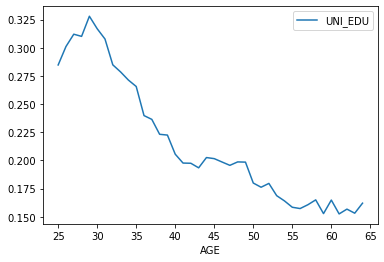

In [82]:
df.groupby('AGE').agg({'UNI_EDU':'mean'})[25:65].plot()

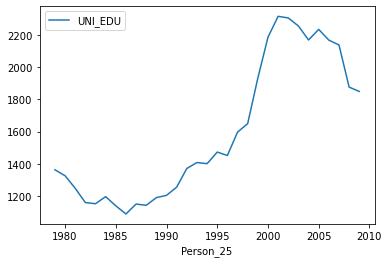

In [83]:
df.groupby('Person_25').agg({'UNI_EDU':'sum'}).loc[1979:2009].plot()

In [84]:
### Segmented Linear Regression

In [85]:
### Divide by sex
#df_25 =df.groupby(['Person_25', 'SEX']).agg({'Edu_years':'mean'}).loc[1975:2009].reset_index() 
#df_25 = df_25[df_25['SEX']==2]
#df_25 = df_25.reset_index(drop=True).reset_index( )

In [107]:
df_25 = df.groupby('Person_25').agg({'UNI_EDU':'mean'}).loc[1960:2010].reset_index().reset_index()
df_25 = df_25.rename(columns={'Person_25': 'year', 'index' : 'time'})
df_25['time'] = df_25['time'] + 1
df_25['change'] = df_25['year'].apply(lambda x : 1 if x >=1990 else 0)
df_25['preslope'] = df_25.apply(lambda x : x['time'] if x['change'] == 0 else -1, axis=1)
df_25['preslope'] = df_25['preslope'].apply(lambda x : df_25['preslope'].max() if x==-1 else x )
df_25['outlier'] = df_25.apply(lambda x : 1 if (x['year']>= 1989 and x['year']<=1999) else 0, axis=1)
df_25['postslope'] = df_25.apply(lambda x : 0 if x['change'] == 0 else x['time'] - x['preslope'], axis=1)
df_25.columns

Index(['time', 'year', 'UNI_EDU', 'change', 'preslope', 'outlier',
       'postslope'],
      dtype='object')

In [108]:
df_25

,time,year,UNI_EDU,change,preslope,outlier,postslope
0,1,1960,0.106025,0,1.0,0,0.0
1,2,1961,0.098374,0,2.0,0,0.0
2,3,1962,0.111814,0,3.0,0,0.0
3,4,1963,0.108419,0,4.0,0,0.0
4,5,1964,0.127556,0,5.0,0,0.0
5,6,1965,0.114692,0,6.0,0,0.0
6,7,1966,0.132673,0,7.0,0,0.0
7,8,1967,0.146994,0,8.0,0,0.0
8,9,1968,0.156962,0,9.0,0,0.0
9,10,1969,0.163077,0,10.0,0,0.0


In [109]:
df_25.to_csv("./data/glsar_test.csv")

In [110]:
fig = px.line(df_25, x="year", y="UNI_EDU")
fig.update_layout(shapes=[
    dict(
      type= 'line',
      yref= 'paper', y0= 0, y1= 1,
      xref= 'x', x0= 1989, x1= 1989
    )
])

In [111]:
multi_regression_model_1 = smf.ols(formula='UNI_EDU ~ time + change + postslope',data=df_25).fit()

# And this gives a big summary of the results:
print(multi_regression_model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                UNI_EDU   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     275.8
Date:                Sun, 17 Jan 2021   Prob (F-statistic):           7.87e-30
Time:                        15:28:46   Log-Likelihood:                 145.78
No. Observations:                  51   AIC:                            -283.6
Df Residuals:                      47   BIC:                            -275.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1145      0.005     21.151      0.0

In [112]:
beta_0, beta_1, beta_2, beta_3 = multi_regression_model_1.params
rsq                    = multi_regression_model_1.rsquared
pval_0, pval_1, pval_2, pval_3 = multi_regression_model_1.pvalues

print("y =", round(beta_1,4), "x1 +", round(beta_2,4), "x2 +", round(beta_3,4), "x3 +", round(beta_0,4) )
print("R^2     = ", rsq)
print("p-value_1 = ", round(pval_1,4))
print("p-value_2 = ", round(pval_2,4))
print("p-value_3 = ", round(pval_3,4))

y = 0.0027 x1 + -0.0234 x2 + 0.0048 x3 + 0.1145
R^2     =  0.9462560148166491
p-value_1 =  0.0
p-value_2 =  0.0072
p-value_3 =  0.0


In [113]:
##
df_25["Y_predict_OLS"] = df_25.apply(lambda x : x.time * beta_1 + x.change * beta_2 + x.postslope * beta_3 + beta_0, axis=1)

In [114]:
#multi_regression_model_2 = smf.ols(formula='UNI_EDU ~ preslope + change + postslope',data=df_25).fit()

# And this gives a big summary of the results:
#print(multi_regression_model_1.summary())

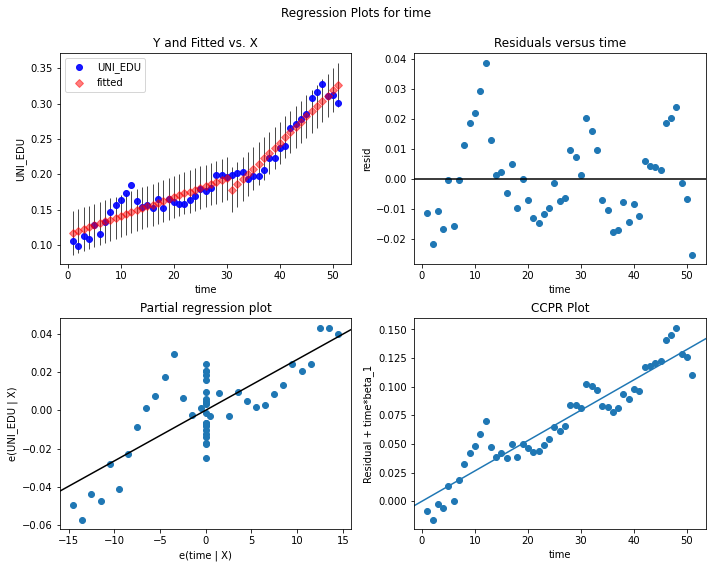

In [115]:
# produce regression plots
fig = plt.figure(figsize=(10,8))
fig = sm.graphics.plot_regress_exog(multi_regression_model_1, 'time', fig=fig)

In [116]:
multi_regression_model_1 = smf.glsar(formula='UNI_EDU ~ time + change + postslope',data=df_25).iterative_fit()
print(multi_regression_model_1.summary())


                           GLSAR Regression Results                           
Dep. Variable:                UNI_EDU   R-squared:                       0.696
Model:                          GLSAR   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     35.18
Date:                Sun, 17 Jan 2021   Prob (F-statistic):           5.72e-12
Time:                        15:28:48   Log-Likelihood:                 161.58
No. Observations:                  50   AIC:                            -315.2
Df Residuals:                      46   BIC:                            -307.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1252      0.019      6.758      0.0

In [117]:
beta_0, beta_1, beta_2, beta_3 = multi_regression_model_1.params
rsq                    = multi_regression_model_1.rsquared
pval_0, pval_1, pval_2, pval_3 = multi_regression_model_1.pvalues

print("y =", round(beta_1,4), "x1 +", round(beta_2,4), "x2 +", round(beta_3,4), "x3 +", round(beta_0,4) )
print("R^2     = ", rsq)
print("p-value_1 = ", round(pval_1,4))
print("p-value_2 = ", round(pval_2,4))
print("p-value_3 = ", round(pval_3,4))

y = 0.0021 x1 + -0.0052 x2 + 0.0041 x3 + 0.1252
R^2     =  0.696427821314499
p-value_1 =  0.0196
p-value_2 =  0.6213
p-value_3 =  0.009


In [118]:
df_25["Y_predict_GLS"] = df_25.apply(lambda x : x.time * beta_1 + x.change * beta_2 + x.postslope * beta_3 + beta_0, axis=1)

In [137]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_25['year'], y=df_25['UNI_EDU'],
                    line=dict(color='blue', width=3),
                    name='Original'))
fig.add_trace(go.Scatter(x=df_25['year'], y=df_25['Y_predict_OLS'],
                    line=dict(color='green', width=2, dash='dash'),
                    name='Prediction - Test 1'))
fig.add_trace(go.Scatter(x=df_25['year'], y=df_25['Y_predict_GLS'],
                    line=dict(color='red', width=2, dash='dot'),
                    name='Prediction - Test 2'))
fig.update_layout(shapes=[
    dict(
      type= 'line',
      yref= 'paper', y0= 0, y1= 1,
      xref= 'x', x0= 1989, x1= 1989
    )
],    xaxis = dict(
        tickmode = 'linear',
        tick0 = 5,
        dtick = 5
    ),
                 legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
),
                     xaxis_title="years",
    yaxis_title="University attainment ratio - 25-year-olds",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="black"
    ))
 

In [120]:
df_25[df_25['year']==2000]

,time,year,UNI_EDU,change,preslope,outlier,postslope,Y_predict_OLS,Y_predict_GLS
40,41,2000,0.239724,1,30.0,0,11.0,0.252072,0.251375


In [142]:
df_sex = df.groupby(['Person_25', 'SEX']).agg({'UNI_EDU':'mean'}).loc[1960:2010].reset_index()


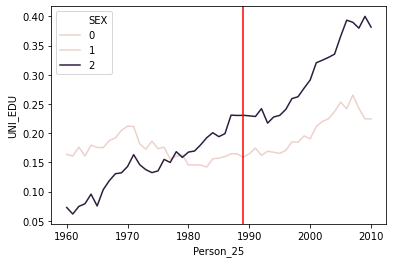

In [145]:
fig, ax = plt.subplots(1)
sns.lineplot(data=df_sex, x='Person_25', y='UNI_EDU', hue="SEX", ax=ax)
plt.axvline(x=1989, color='r', label='axvline - full height')

In [146]:
fig = px.line(df_sex, x="Person_25", y="UNI_EDU", color='SEX')
fig.update_layout(shapes=[
    dict(
      type= 'line',
      yref= 'paper', y0= 0, y1= 1,
      xref= 'x', x0= 1989, x1= 1989
    )
])

In [173]:
df_sex_male = df_sex[df_sex['SEX']==1]
df_sex_female = df_sex[df_sex['SEX']==2]

In [174]:
df_sex_female = df_sex_female.reset_index().rename(columns={'Person_25': 'year', 'index' : 'time'})
df_sex_female['time'] = df_sex_female['time'] + 1
df_sex_female['change'] = df_sex_female['year'].apply(lambda x : 1 if x >=1990 else 0)
df_sex_female['preslope'] = df_sex_female.apply(lambda x : x['time'] if x['change'] == 0 else -1, axis=1)
df_sex_female['preslope'] = df_sex_female['preslope'].apply(lambda x : df_sex_female['preslope'].max() if x==-1 else x )
df_sex_female['outlier'] = df_sex_female.apply(lambda x : 1 if (x['year']>= 1989 and x['year']<=1999) else 0, axis=1)
df_sex_female['postslope'] = df_sex_female.apply(lambda x : 0 if x['change'] == 0 else x['time'] - x['preslope'], axis=1)
df_sex_female.columns

Index(['time', 'year', 'SEX', 'UNI_EDU', 'change', 'preslope', 'outlier',
       'postslope'],
      dtype='object')

In [175]:
fig = px.line(df_sex_female, x="year", y="UNI_EDU")
fig.update_layout(shapes=[
    dict(
      type= 'line',
      yref= 'paper', y0= 0, y1= 1,
      xref= 'x', x0= 1989, x1= 1989
    )
])

In [182]:
multi_regression_model_1 = smf.ols(formula='UNI_EDU ~ time + change + postslope',data=df_sex_female).fit()

# And this gives a big summary of the results:
print(multi_regression_model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                UNI_EDU   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     650.8
Date:                Tue, 12 Jan 2021   Prob (F-statistic):           2.90e-38
Time:                        14:40:29   Log-Likelihood:                 144.23
No. Observations:                  51   AIC:                            -280.5
Df Residuals:                      47   BIC:                            -272.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0656      0.006     11.754      0.0

In [ ]:
multi_regression_model_2 = smf.ols(formula='UNI_EDU ~ preslope + change + postslope',data=df_sex_female).fit()

# And this gives a big summary of the results:
print(multi_regression_model_1.summary())

In [178]:
df_sex_male = df_sex_male.reset_index().rename(columns={'Person_25': 'year', 'index' : 'time'})
df_sex_male['time'] = df_sex_male['time'] + 1
df_sex_male['change'] = df_sex_male['year'].apply(lambda x : 1 if x >=1990 else 0)
df_sex_male['preslope'] = df_sex_male.apply(lambda x : x['time'] if x['change'] == 0 else -1, axis=1)
df_sex_male['preslope'] = df_sex_male['preslope'].apply(lambda x : df_sex_male['preslope'].max() if x==-1 else x )
df_sex_male['outlier'] = df_sex_male.apply(lambda x : 1 if (x['year']>= 1989 and x['year']<=1999) else 0, axis=1)
df_sex_male['postslope'] = df_sex_male.apply(lambda x : 0 if x['change'] == 0 else x['time'] - x['preslope'], axis=1)
df_sex_male.columns

Index(['time', 'year', 'SEX', 'UNI_EDU', 'change', 'preslope', 'outlier',
       'postslope'],
      dtype='object')

In [179]:
fig = px.line(df_sex_male, x="year", y="UNI_EDU")
fig.update_layout(shapes=[
    dict(
      type= 'line',
      yref= 'paper', y0= 0, y1= 1,
      xref= 'x', x0= 1989, x1= 1989
    )
])

In [180]:
multi_regression_model_1 = smf.ols(formula='UNI_EDU ~ time + change + postslope',data=df_sex_male).fit()

# And this gives a big summary of the results:
print(multi_regression_model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                UNI_EDU   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     45.52
Date:                Tue, 12 Jan 2021   Prob (F-statistic):           6.02e-14
Time:                        12:11:13   Log-Likelihood:                 141.39
No. Observations:                  51   AIC:                            -274.8
Df Residuals:                      47   BIC:                            -267.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1856      0.006     32.244      0.0

In [181]:
multi_regression_model_1 = smf.ols(formula='UNI_EDU ~ preslope + change + postslope',data=df_sex_male).fit()

# And this gives a big summary of the results:
print(multi_regression_model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                UNI_EDU   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     45.52
Date:                Tue, 12 Jan 2021   Prob (F-statistic):           6.02e-14
Time:                        12:11:13   Log-Likelihood:                 141.39
No. Observations:                  51   AIC:                            -274.8
Df Residuals:                      47   BIC:                            -267.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1856      0.006     32.244      0.0